In [46]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [72]:
dataset = pd.read_csv('../dataset/healthcare-dataset-stroke-data.csv')

dataset.replace( {'Male': 0,'Female':1, 'No': 0, 'Yes': 1, 'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4 }, inplace=True)
dataset.replace( {'Urban': 0, 'Rural': 1, 'formerly smoked': 1, 'never smoked': 0, 'smokes': 2, 'Unknown': 4 }, inplace=True)
dataset.drop(['smoking_status','Residence_type','ever_married','work_type','hypertension','heart_disease','avg_glucose_level'], axis=1,inplace=True)
dataset.dropna(inplace=True)

features_names = ['gender','age','bmi' ]
target_names = 'stroke'

target = dataset[target_names]
feature = dataset[features_names]

print(target.shape)
print(feature.shape)


(891,)
(891, 3)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,target,
    test_size=0.2,
    random_state=np.random.randint(10))

In [74]:
batch_size = 32
X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(float)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)

X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(float)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

In [80]:
from tensorflow import keras

inputs = keras.Input(shape=(3,))
h1 = keras.layers.Dense(10,activation=tf.nn.sigmoid)(inputs)
h2 = keras.layers.Dense(3,activation=tf.nn.sigmoid)(h1)
outputs = keras.layers.Dense(2)(h2)
model = keras.Model(inputs=inputs, outputs=outputs, name="stroke_model")

model.summary()

Model: "stroke_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_24 (Dense)            (None, 10)                40        
                                                                 
 dense_25 (Dense)            (None, 3)                 33        
                                                                 
 dense_26 (Dense)            (None, 2)                 8         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [76]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [79]:
next_batch_dataset = next(iter(train_dataset))
features,labels = next_batch_dataset
predictions = model(features)

print(f"Prediction: {tf.argmax(predictions, axis=1)}")
print(f"    Labels: {labels}")

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0.]


In [66]:
def loss(model, x, y, training):
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print(f"Loss test: {l}")

Loss test: 0.6900315284729004


In [67]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [68]:
loss_value, grads = grad(model, features, labels)

print(f"Step: {optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")

optimizer.apply_gradients(zip(grads, model.trainable_variables))
print(f"Step: {optimizer.iterations.numpy()}, Loss: {loss(model, features, labels, training=True).numpy()}")



Step: 0, Initial Loss: 0.6900315284729004
Step: 1, Loss: 0.6876013278961182


In [69]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  
        epoch_accuracy.update_state(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    print(f"Epoch {epoch:03d}: Loss: {epoch_loss_avg.result():.3f}, Accuracy: {epoch_accuracy.result():.3%}")

Epoch 000: Loss: 0.666, Accuracy: 66.854%
Epoch 001: Loss: 0.627, Accuracy: 76.826%
Epoch 002: Loss: 0.603, Accuracy: 76.826%
Epoch 003: Loss: 0.587, Accuracy: 76.826%
Epoch 004: Loss: 0.576, Accuracy: 76.826%
Epoch 005: Loss: 0.568, Accuracy: 76.826%
Epoch 006: Loss: 0.563, Accuracy: 76.826%
Epoch 007: Loss: 0.559, Accuracy: 76.826%
Epoch 008: Loss: 0.556, Accuracy: 76.826%
Epoch 009: Loss: 0.553, Accuracy: 76.826%


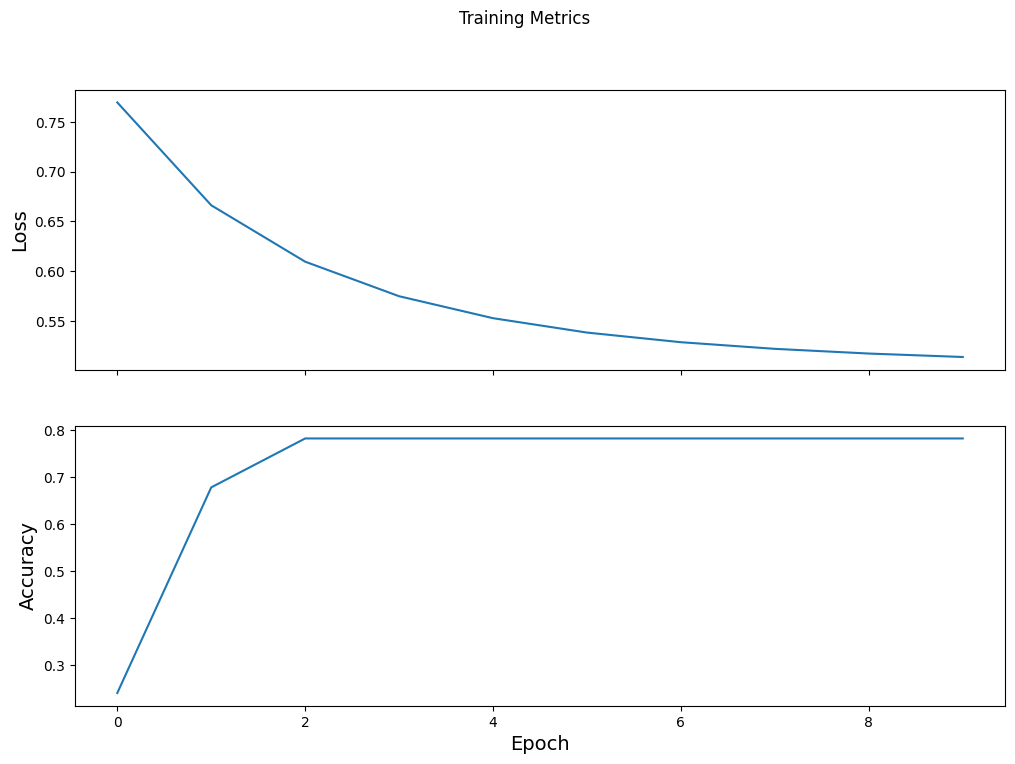

In [57]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [70]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print(f"Test set accuracy: {test_accuracy.result():.3%}")

Test set accuracy: 75.419%


In [71]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model/assets
